# Business Problem: Predicting Flood Losses
Most insurance carriers do not offer flood insurance for homes and other structures. Instead, the U.S. government offers flood insurance through the National Flood Insurance Program (NFIP). According to the NFIP, 90% of natural disasters involve flood but only 12-14% of households purchase flood insurance. Banks require households to purchase a flood policy for structures that sit within a flood plain, but banks do not require households to verify that the policy coverage is updated over time as structures are improved or as inflation increases the cost to replace the structure.

Using claims data acquired from the NFIP, we will build a model to predict whether a policy is underinsured. Underinsured policies occur when a flood loss exceeds the limits specified in the flood insurance contract. This model can be used by homeowners to ensure coverage adequately protects them against flood risks and for the NFIP to ensure policies carry suitable limits, which helps provide sufficient total premiums to cover losses when they do occur. This model can also insulate taxpayers by lessening the need for government agencies to bailout uninsured and underinsured individuals when catastrophes occur.

Our analysis will not predict the probability of a household incurring a flood loss. This problem would require a specific listing of flood policies and historical information about floods within each geographic area. Because most households acquire a loan to purchase a property, and because banks compel homeowners to carry flood insurance when risks are present, a model predicting probability of a loss feels unnecessary.


### Data Source - National Flood Insurance Program (NFIP) Claims: 
- Loss information is tracked for each policy issued by the NFIP. Total losses per claim are provided, and there are additional policy attributes that will help us assess the total insured losses per unit of covered risk.
- Data last updated: 4/22/2022
- This data set is available through an API and csv. We will use the csv flat file for this project. Link to data: https://www.fema.gov/openfema-data-page/fima-nfip-redacted-claims-v1
- Data dictionary can also be found at the link above.

### Target Variable for Our Prediction
The model target is the *underinsured indicator* on each claim (1 if True; 0 if False). A claim is deemed underinsured if the claim payment for the building loss is equal to or exceeds the policy limit for building coverage. This field is not available in the NFIP data, but we can calculate it by comparing the two fields noted (building loss amount and building coverage amount).

Because the NFIP will not pay more than a policy’s limit specifies, we can not measure or evalute how much a policy is underinsured. Without the total insured loss, we can not suggest appropriate policy limits for underinsured policies. Our model will only seek to identify underinsured policies.

## PREPROCESSING

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from imblearn.over_sampling import SMOTE

In [2]:
# Import Claims NFIP dataset. Data sourced from the site above.

FILE = 'FimaNfipClaims.csv'

claims_df = pd.read_csv(FILE)

In [3]:
# List of fields available for our analysis.

claims_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2568936 entries, 0 to 2568935
Data columns (total 40 columns):
 #   Column                                      Dtype  
---  ------                                      -----  
 0   agricultureStructureIndicator               float64
 1   asOfDate                                    object 
 2   baseFloodElevation                          float64
 3   basementEnclosureCrawlspace                 float64
 4   reportedCity                                object 
 5   condominiumIndicator                        object 
 6   policyCount                                 float64
 7   countyCode                                  float64
 8   communityRatingSystemDiscount               float64
 9   dateOfLoss                                  object 
 10  elevatedBuildingIndicator                   float64
 11  elevationCertificateIndicator               float64
 12  elevationDifference                         float64
 13  censusTract                

**Step 1: Convert Data Types**

Some of the indicators and the year of loss variable were converted to float values upon import. This will create issues within our model and need to be converted to objects.

In [4]:
# Convert indicator fields from float to objects.

INDICATORFIELDS = ['agricultureStructureIndicator', 'countyCode', 'elevatedBuildingIndicator',
                   'houseWorship', 'nonProfitIndicator', 'occupancyType', 'obstructionType',
                   'postFIRMConstructionIndicator', 'yearOfLoss', 'reportedZipcode',
                   'primaryResidence', 'smallBusinessIndicatorBuilding', 'communityRatingSystemDiscount']

for x in INDICATORFIELDS:
    claims_df[x] = claims_df[x].astype('object')

In [5]:
# Verify fields were converted to floats.

claims_df[INDICATORFIELDS].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2568936 entries, 0 to 2568935
Data columns (total 13 columns):
 #   Column                          Dtype 
---  ------                          ----- 
 0   agricultureStructureIndicator   object
 1   countyCode                      object
 2   elevatedBuildingIndicator       object
 3   houseWorship                    object
 4   nonProfitIndicator              object
 5   occupancyType                   object
 6   obstructionType                 object
 7   postFIRMConstructionIndicator   object
 8   yearOfLoss                      object
 9   reportedZipcode                 object
 10  primaryResidence                object
 11  smallBusinessIndicatorBuilding  object
 12  communityRatingSystemDiscount   object
dtypes: object(13)
memory usage: 254.8+ MB


In [6]:
# Fill blanks in dates. Blanks are minimal, so we'll use a dummy date at start of 2022.

claims_df['originalNBDate'] = claims_df['originalNBDate'].fillna('2022-01-01 12:00:00+00:00')
claims_df['originalConstructionDate'] = claims_df['originalConstructionDate'].fillna('2022-01-01 12:00:00+00:00')

# Convert original NB date and construction date fields to datetime.

claims_df['originalNBDate'] = pd.to_datetime(claims_df['originalNBDate'], utc=True)
claims_df['originalConstructionDate'] = pd.to_datetime(claims_df['originalConstructionDate'])

In [7]:
# Verify date conversion.

claims_df[['originalNBDate', 'originalConstructionDate']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2568936 entries, 0 to 2568935
Data columns (total 2 columns):
 #   Column                    Dtype              
---  ------                    -----              
 0   originalNBDate            datetime64[ns, UTC]
 1   originalConstructionDate  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](2)
memory usage: 39.2 MB


**Step 2: Create Total & Loss Target Variable**

The claims data splits claims payments into 3 categories - building losses, contents losses, and government special payments. Most analysis will likely focus on a total, so this step adds a total loss column comprised of the 3 loss components.

For measuring underinsured values, this analysis will focus on the building coverage. In cases where the claim payment exceeds or is equal to the limits provided by the insurance policy, we will declare that a total loss. In these cases, the insured likely did not get fully compensated for their loss and will be deemed "underinsured".

As noted in the analysis below, there are 23% of claims where no payment was issued. No comment was made in the documentation regarding errors with payments. Claims without payment are likely people who filed a claim but were deemed not covered by their insurance policy. For measuring severity of a claim, we will remove these records from our data set.

In [8]:
# Replace NaN values with zeros for the 3 payment and 2 coverage fields.

TARGETFIELDS = ['amountPaidOnBuildingClaim', 'amountPaidOnContentsClaim', 'amountPaidOnIncreasedCostOfComplianceClaim',
                'totalBuildingInsuranceCoverage', 'totalContentsInsuranceCoverage']

for x in TARGETFIELDS:
    claims_df[x] = claims_df[x].fillna(0)

In [9]:
# Create total loss field.

claims_df['Total_Loss'] = claims_df['amountPaidOnBuildingClaim'] + claims_df['amountPaidOnContentsClaim'] +\
                          claims_df['amountPaidOnIncreasedCostOfComplianceClaim']

In [10]:
# Identify whether the claim was underinsured. The measure is whether the loss paid on buildings exceeds the loss
# coverage amount.

claims_df['Underinsured'] = 0

claims_df.loc[(claims_df['amountPaidOnBuildingClaim']>=claims_df['totalBuildingInsuranceCoverage']) &
              (claims_df['Total_Loss']>0), 'Underinsured'] = 1

In [11]:
# Measure claims where total paid losses are 0.

loss_free_count = claims_df.loc[claims_df['Total_Loss']==0]['id'].count()

print(f'Total Number of Claims without Payment: {loss_free_count}')
print(f'Percentage of Claims without Payment:{loss_free_count/claims_df.shape[0]:.2f}')

Total Number of Claims without Payment: 580906
Percentage of Claims without Payment:0.23


In [12]:
# Remove claims where no payment was issued.

claims_df = claims_df.loc[claims_df['Total_Loss']>0]

## EXPLORATORY DATA ANALYSIS

An evaluation of the total flood losses and distribution of underinsured policies will aid in identifying suitable features for our model. We will need to understand the nature of flood losses, which is reviewed over time, by event, and by geography. Distributions of underinsureds are presented to identify any adjustments required for modeling.

**Total Flood Losses by Year**<br>
Flood losses have trended higher since the 1970’s. Within the 2000-2020 years, there have been several large flooding events caused by hurricanes. Spikes in the data are evident in the chart below.

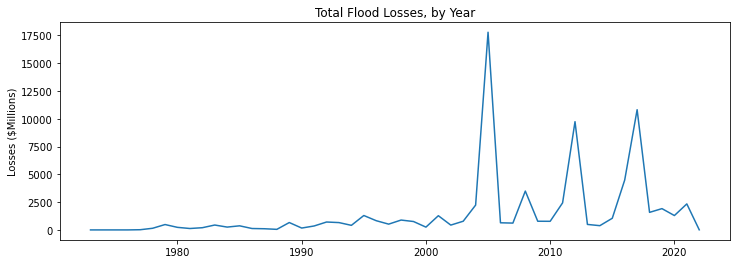

In [13]:
# Group total losses by year and graph.

plt.figure(figsize=(12,4))
loss_year_df = claims_df.groupby('yearOfLoss', as_index=False)['Total_Loss'].sum()

plt.plot(loss_year_df['yearOfLoss'], loss_year_df['Total_Loss']/1000000);
plt.title('Total Flood Losses, by Year');
plt.ylabel('Losses ($Millions)');

**Flood Losses by Major Catastrophe Event**<br>
Based on the information from the Insurance Institute, the large losses in 2005, 2012, and 2017 are the result of certain events. Large losses are considered rare (low probability of occurring over time). Additional exploration of underinsureds for these events is needed to ensure model predictions aren't overly influenced by these rare events.

Top 10 Most Significant Flood Events By National Flood Insurance Program Payouts (1)

|Rank|Date	    | Event	     | Claim No.| Amount paid(M)	| Average paid loss |
|---|---      | ---              |---       |---              |---                |
|1 |Aug. 2005|	Hurricane Katrina|	168,256|16,092|     	95,640|
|2 |	Sep. 2017|	Hurricane Harvey|	78,254|	9,171|	117,192|
|3 |	Oct. 2012|	Superstorm Sandy|	132,897|	8,619|	64,852|
|4 |	Sep. 2008|	Hurricane Ike|	47,247|	2,670|	56,517|
|5 |	Aug. 2016|	Louisiana severe storms and flooding|	27,737|	2,536|	91,432|
|6 |	Sep. 2004|	Hurricane Ivan|	31,981|	1,688|	52,791|
|7 |	Sep. 2021|	Hurricane Ida|	28,544|	1,589|	55,658|
|8 |	Sep. 2004|	Hurricane Jeanne|	31,486|	1,513|	48,062|
|9 |Aug. 2011|	Hurricane Irene|	44,178|	1,321|	29,894|
|10|	Sep. 2017|	Hurricane Irma|	23,119|	1,153|	49,884|


(1) Includes events from 1978 to December 31, 2021 as of March 9, 2022. Defined by the National Flood Insurance Program as an event that produces at least 1,500 paid losses. Stated in dollars when occurred.

Hurricane Katrina in 2005 resulted in massive flooding that submerged a lot of the New Orleans area for weeks. This flooding event resulted in many total property losses within New Orleans. The rarity and significance of this flood resulted in a large spike in underinsured losses. We will need to adjust for this in our modeling to avoid this rare event overinfluencing our target projections. This may require building a model without Katrina losses or balancing other underinsured losses to compensate for the larger percentage of Katrina claims. Exhibits below show spikes in underinsureds during 2005 and for the state of Louisiana.

In [14]:
# Presenting the number of underinsureds over time.

underinsured_count = claims_df.pivot_table(index='yearOfLoss', columns='Underinsured', values='id', aggfunc='count')

underinsured_count = underinsured_count.rename(columns={0:'Proper_Coverage', 1:'Underinsured'}).reset_index()

# Calculate percentage of underinsured
underinsured_count['Percent_Underinsured'] = (underinsured_count['Underinsured'] / (underinsured_count['Proper_Coverage']+underinsured_count['Underinsured']))

In [15]:
# Calculate the average percent underinsured across all years.

avg_underinsured = sum(underinsured_count['Underinsured'].dropna()) / (sum(underinsured_count['Proper_Coverage'].dropna()) +\
                                                                       sum(underinsured_count['Underinsured'].dropna()))

print('{:.2f}'.format(avg_underinsured))

0.12


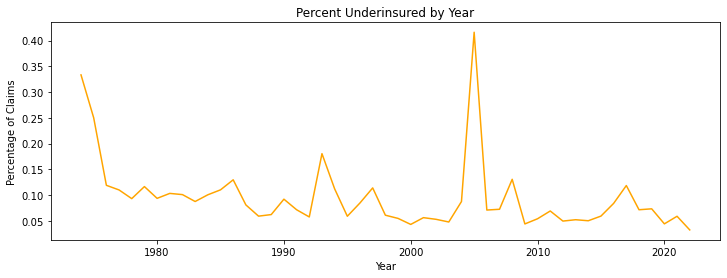

In [16]:
# Create a stacked bar chart of underinsured vs. properly insured.
plt.figure(figsize=(12,4))

sns.lineplot(data=underinsured_count, x='yearOfLoss', y='Percent_Underinsured', legend=None, color='orange');
plt.title('Percent Underinsured by Year');
plt.xlabel('Year');
plt.ylabel('Percentage of Claims');

In [17]:
# Calculate the number and percentage of underinsureds by state.

underinsured_count_st = claims_df.pivot_table(index='state', columns='Underinsured', values='id', aggfunc='count')

underinsured_count_st = underinsured_count_st.rename(columns={0:'Proper_Coverage', 1:'Underinsured'}).reset_index()

# Calculate percentage of underinsured
underinsured_count_st['Percent_Underinsured'] = (underinsured_count_st['Underinsured'] / (underinsured_count_st['Proper_Coverage']+underinsured_count_st['Underinsured']))

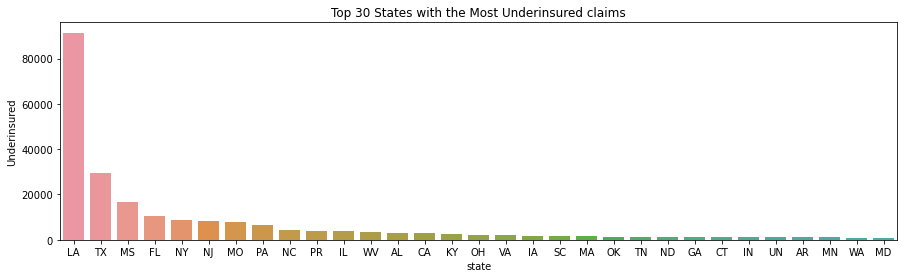

In [18]:
# Create a stacked bar chart of underinsured vs. properly insured.
plt.figure(figsize=(15,4))

# Organize data by most underinsureds for graphing.
underinsured_count_st = underinsured_count_st.sort_values(by='Underinsured', ascending=False)

# Graph underinsured counts
sns.barplot(data=underinsured_count_st, x='state', y='Underinsured');
plt.title('Top 30 States with the Most Underinsured claims');
plt.xlim([-0.5,30.5]);

**Geographic Split of Underinsured Losses**<br>
Geographic location may influence the rate of underinsured. Geographic location may be influenced by trends in property inflation or economic status of homeowners. It may also be influenced by the presence of large flooding events; those that cause substantial damage likely to exceed homeowner policy limits. It will be important to assess causes of geographic results when building features.

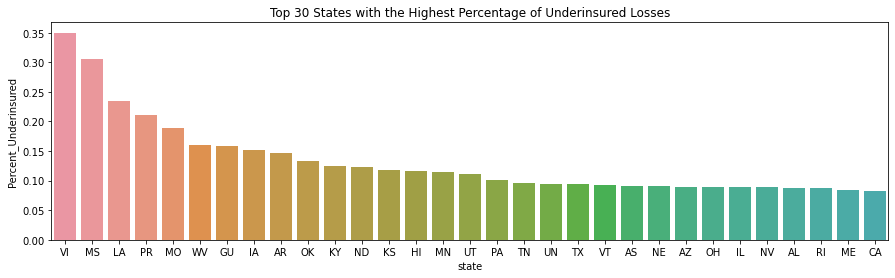

In [19]:
# Create a stacked bar chart of underinsured percentage.
plt.figure(figsize=(15,4))

# Organize data by highest underinsured percentage for graphing.
underinsured_count_st = underinsured_count_st.sort_values(by='Percent_Underinsured', ascending=False)

# Graph underinsured counts
sns.barplot(data=underinsured_count_st, x='state', y='Percent_Underinsured');
plt.title('Top 30 States with the Highest Percentage of Underinsured Losses');
plt.xlim([-0.5,30.5]);

**Split of Underinsureds by Occupancy Type**<br>
Occupancy type appears to be a meaningful variable for our model. Non-residential buildings have a higher percentage of underinsured losses while single family residences have a lower than average value. Categories may need to be grouped to ensure there are enough samples in each category to be meaningful. Also, there is a percentage of “unknowns” that will need to be addressed within our model.

In [20]:
# Calculate the number and percentage of underinsureds by occupancy type.

underinsured_occup = claims_df.pivot_table(index='occupancyType', columns='Underinsured', values='id', aggfunc='count')

underinsured_occup = underinsured_occup.rename(columns={0:'Proper_Coverage', 1:'Underinsured'}).reset_index()

# Calculate percentage of underinsured
underinsured_occup['Percent_Underinsured'] = (underinsured_occup['Underinsured'] / (underinsured_occup['Proper_Coverage']+underinsured_occup['Underinsured']))

In [21]:
# Translate values in Occupancy Type Field to Labels.

occ_codes = {'1': 'Single family residence', 
             '2': '2-4 unit residential building',
             '3': 'Residential building 4+ units',
             '4': 'Non-residential building',
             '11': 'Single-family residential building',
             '12': 'Residential non-condo building with 2-4 units', 
             '13': 'Residential non-condo building with 5+ units',
             '14': 'Residential mobile/manufactured home', 
             '15': 'Residential condo association',
             '16': 'Single residential unit within a multi-unit building',
             '17': 'Non-residential mobile/manufactured home',
             '18': 'Non-residential building',
             '19': 'Non-residential unit within a multi-unit building'}

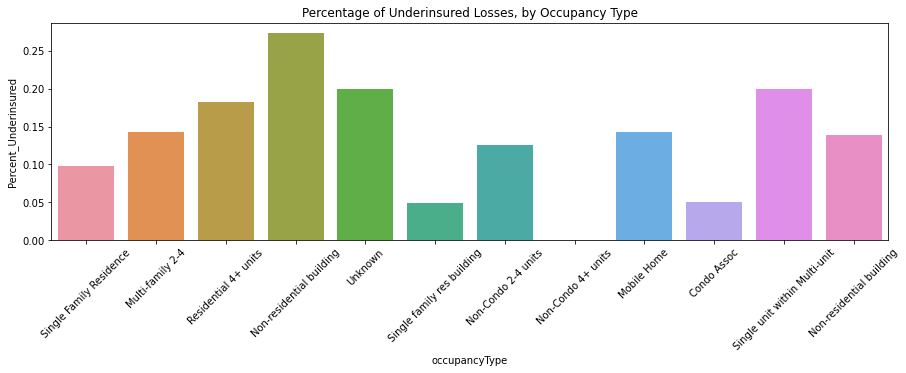

In [22]:
# Create a stacked bar chart of underinsured vs. properly insured.
plt.figure(figsize=(15,4))

# Organize data by most underinsureds for graphing.
underinsured_occup = underinsured_occup.sort_values(by='Underinsured', ascending=False)

# Graph underinsured counts
sns.barplot(data=underinsured_occup, x='occupancyType', y='Percent_Underinsured');
plt.title('Percentage of Underinsured Losses, by Occupancy Type');
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9,10,11], 
           labels=['Single Family Residence', 'Multi-family 2-4', 'Residential 4+ units',
           'Non-residential building', 'Unknown', 'Single family res building',
           'Non-Condo 2-4 units', 'Non-Condo 4+ units', 'Mobile Home', 'Condo Assoc',
           'Single unit within Multi-unit', 'Non-residential building'],
          rotation=45);


### EDA Summary
The data set contains a number of additional elements about the property structure, occupancy reason, and geographic location to use for the model. Early review of the features above suggest at least some should be predictive. 

The data set includes 2.6M claim records, which should be sufficient for modeling. Twenty-three percent of claims will need to be excluded as no loss was ever paid. The net retained records of 2M should be sufficient for modeling.

While the data set likely contains enough features and data for modeling, consideration will need to be inbalanced target class and the presence of larger, rare events that may be distorting our target variable and features.  

# MILESTONE 2: Feature Extraction and Engineering

#### Step 1: Drop Columns Not Relevant for Modeling

There are a few fields that will not be relevant for modeling. These include:
- 'id': Field is a randomized identifier of record for matching to NFIP internal database. Not usable or interpretable otherwise.
- 'asOfDate': Field is system timestamp of data refresh. Delete due to system key.
- 'longitude': Remove longitude field. We will be using city and state as factors; this is duplicative.
- 'latitude': Remove latitude field. We will be using city and state as factors; this is duplicative.
- 'reportedCity': This data is listed as "Temporarily Unavailable" and will need to be dropped.
- 'reportedZipcode': Remove as we will use state for our model. Zipcode may  be too granular to derive correlations given the sparcity of claims within each zipcode (other than Katrina or megacats).
- 'censusTract': Another measurement of location, focusing on geolocation. We will use state and county for our model.
- 'dateOfLoss': 'dateOfLoss' overlaps with year of loss and is too granular given the sparcity of claims on a given day.
- 'policyCount': The principal value is 1, but there are a very small percentage of policies with a value greater than 1. Due to the low variance of this feature and the number of columns this produces, this feature will be removed to improve model run performance (300 columns are removed). 
- Several variables were removed as earlier runs with these variables did not improve the F1 Score:
    - 'originalConstructionDate', 'originalNBDate', 'elevationCertificateIndicator', elevationDifference', 'baseFloodElevation'

The model is having difficulty processing steps due to data size. We will eliminate 'countyCode' to get an initial assessment. County is the most sparce and has some overlap with state. We will re-evaluate this after preliminary modeling.

In [23]:
# Remove all fields, noted above, with no modeling value.

del_fields = ['id', 'asOfDate', 'longitude', 'latitude', 'reportedCity', 'reportedZipcode', 
              'countyCode', 'censusTract', 'dateOfLoss', 'policyCount', 'originalConstructionDate', 
              'originalNBDate', 'elevationCertificateIndicator', 'elevationDifference', 'baseFloodElevation',
             ]

claims_df_pipeline = claims_df.drop(del_fields, axis=1)

### Step 2: Remove all columns where our null values exceed 30% of the records.

In [24]:
# Remove all fields with more than 30% null values.
max_null_records = claims_df_pipeline.shape[0] * 0.30

# Find columns with excessive nulls.
null_cols = claims_df_pipeline.columns[claims_df_pipeline.isnull().sum() > max_null_records]

# Drop columns
try:
    claims_df_pipeline = claims_df_pipeline.drop(null_cols, axis=1)
except:
    print('Columns were not deleted. These columns may have already been deleted.')

#### Step 3: Remove features used to construct our target variable.
The target variable is uninsured (y/n). The target value was constructed using loss values, which will be highly correlated. We are also removing loss values, because our model is trying to predict whether a policy is uninsured and claims data will not be present when insured purchase their limit.

In [25]:
# List of fields with data about the claim, including those used to construct our target variable.

loss_fields = ['amountPaidOnBuildingClaim','amountPaidOnContentsClaim', 'amountPaidOnIncreasedCostOfComplianceClaim',
               'Total_Loss', 'yearOfLoss']

# Remove claims-related fields.
try:
    claims_df_pipeline = claims_df_pipeline.drop(loss_fields, axis=1)
except:
    print('Columns were not deleted. These columns may have already been deleted.')

In [26]:
# Verify number of columns deleted from model pipeline after steps 1-3.
print(f'Original columns in dataframe: {claims_df.shape[1]}')
print(f'Columns in model pipeline after steps 1-3: {claims_df_pipeline.shape[1]}')
print(f'Removed columns: {claims_df.shape[1] - claims_df_pipeline.shape[1]}')

Original columns in dataframe: 42
Columns in model pipeline after steps 1-3: 18
Removed columns: 24


#### Step 4: Fill all NA Values in Remaining Fields

In [27]:
# Identify all Null Values

claims_df_pipeline.isnull().sum()

agricultureStructureIndicator             61
condominiumIndicator                   27810
elevatedBuildingIndicator                 61
floodZone                             106613
houseWorship                              61
locationOfContents                         0
lowestFloorElevation                       0
numberOfFloorsInTheInsuredBuilding     12526
nonProfitIndicator                        61
occupancyType                            518
postFIRMConstructionIndicator             61
rateMethod                             41233
smallBusinessIndicatorBuilding            61
state                                      9
totalBuildingInsuranceCoverage             0
totalContentsInsuranceCoverage             0
primaryResidence                           3
Underinsured                               0
dtype: int64

In [28]:
# Populate 'floodZone' with "NoFLood".

claims_df_pipeline['floodZone'] = claims_df_pipeline['floodZone'].fillna('No')

In [29]:
# Remaining values are generally a very small percentage, except rateMethod. We will populate these with the mode.

for c in claims_df_pipeline.columns:
    claims_df_pipeline[c].fillna(claims_df_pipeline[c].mode()[0], inplace=True)    

In [30]:
# Verify no nulls remain in the pipeline.

claims_df_pipeline.isnull().sum()

agricultureStructureIndicator         0
condominiumIndicator                  0
elevatedBuildingIndicator             0
floodZone                             0
houseWorship                          0
locationOfContents                    0
lowestFloorElevation                  0
numberOfFloorsInTheInsuredBuilding    0
nonProfitIndicator                    0
occupancyType                         0
postFIRMConstructionIndicator         0
rateMethod                            0
smallBusinessIndicatorBuilding        0
state                                 0
totalBuildingInsuranceCoverage        0
totalContentsInsuranceCoverage        0
primaryResidence                      0
Underinsured                          0
dtype: int64

#### Step 5: Run a Correlation Matrix to Assess Correlated Values
The numerical features are not highly correlated. No adjustments to numerical fields are necessary.

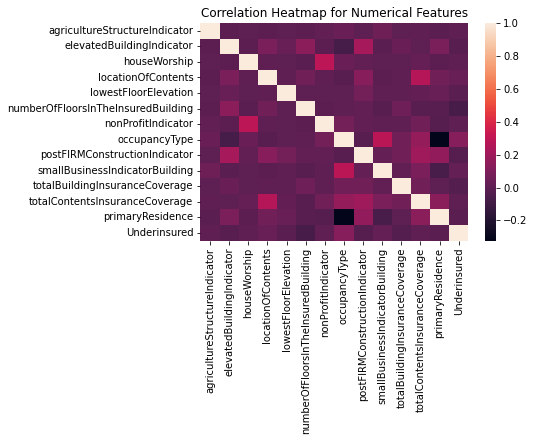

In [31]:
corr_values = claims_df_pipeline.corr()

sns.heatmap(corr_values);
plt.title('Correlation Heatmap for Numerical Features');

#### Step 6: Create Dummy Variables for all Categorical Variables. Save to Pipeline V2.

In [32]:
# Identify all columns that are non-numerics.

obj_cols = [c for c in claims_df_pipeline.columns if claims_df_pipeline[c].dtypes=='object']

In [33]:
# Create dummy variables for categorical variables.

claims_df_pipeline2 = pd.get_dummies(claims_df_pipeline, columns=obj_cols, drop_first=True)

In [34]:
# Verify shape of outputs.
print(f'Shape of original pipeline: {claims_df_pipeline.shape}')
print(f'Shape of onehot pipeline: {claims_df_pipeline2.shape}')

Shape of original pipeline: (1987956, 18)
Shape of onehot pipeline: (1987956, 166)


#### Step 7: Measure Class Imbalance of Target Variable
There is an imbalance in our classes for our target variable. The underinsured population represents 11.7% of the population. When building our model sample set, we will need to consider methods to balance the classes.

In [35]:
print('Percentage of properly underinsured(1) claims in target:')
claims_df_pipeline2['Underinsured'].value_counts(normalize=True)

Percentage of properly underinsured(1) claims in target:


0    0.883188
1    0.116812
Name: Underinsured, dtype: float64

# MILESTONE 3: Modeling

Our model is to classify whether a customer with a loss is likely to be underinsured. We will use two models, logistic regression and a random forest model, to predict underinsureds. 

Models will need to be scaled, using StandardScaler, and will need to account for imbalance in the target class. SMOTE is a synthetic oversampling technique that will allow us to equalize the number of observations of the underinsured class. 

Our original feature set contained 500+ columns. Initial attempts to use PCA and Linear Discriminant Analysis were ineffective is significantly reducing features. Through iteration, categorical variables noted in section 2 were removed that did help our performance metric.

Because we are predicting underinsureds, a relatively small portion of the data set, we will use the F1 score as our performance metric. 

#### Step 1: Split Data into Train and Test Sets

In [36]:
# Split target variable and features.

target = claims_df_pipeline2['Underinsured']
features = claims_df_pipeline2.drop(['Underinsured'], axis=1)

# Split data into train and test with 30% reserved for testing.

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.3)

#### Step 2: Create a Scaled Dataset and Apply Logistic Regression

In [37]:
# Apply standardization to training set.

scaler = StandardScaler()
x_train_std = scaler.fit_transform(x_train)

# Apply fitted scaler to test set.

x_test_std = scaler.transform(x_test)

In [38]:
# Build Logistic Regression Model.

log_reg = LogisticRegression(max_iter=1000)
log_model = log_reg.fit(x_train_std, y_train)

In [39]:
# Predict y values on test set.

y_pred = log_model.predict(x_test_std)

In [40]:
# Print confusion matrix.

print('Confusion Matrix:')
pd.DataFrame(confusion_matrix(y_test, y_pred),columns=['Pred: 0', 'Pred: 1'], index=['Actual: 0', 'Actual: 1'])

Confusion Matrix:


,Pred: 0,Pred: 1
Actual: 0,522327,4432
Actual: 1,63002,6626


In [41]:
# Print Precision, Recall, and F1

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94    526759
           1       0.60      0.10      0.16     69628

    accuracy                           0.89    596387
   macro avg       0.75      0.54      0.55    596387
weighted avg       0.86      0.89      0.85    596387



**Summary of Logistic Regression**

While our model achieves an 89% accuracy score, the model does not predict our underinsured very well. Underinsured is only predicted accurately 10,468 times while it does the false negatives are 58,945. Another way to look at this model is that the underinsured is only 11% of the total population, so our model is only marginally better than assuming all values are properly insured (i.e. not underinsureds).

#### Step 3: Rerun Logistic Regression after Oversampling Target Class

In [42]:
# Apply standardization to training set.

scaler = StandardScaler()
x_train_std = scaler.fit_transform(x_train)

# Apply fitted scaler to test set.

x_test_std = scaler.transform(x_test)

In [43]:
# Apply resampling using SMOTE
# WARNING: THIS CELL RUN TIME IS ~2 MIN

sm = SMOTE()
x_train_stdres, y_train_res = sm.fit_resample(x_train_std, y_train)

In [44]:
# Verify the shape of resampled data.

print(f'Shape of resampled feature set: {x_train_stdres.shape}')

# Verify the target variable is balanced.

print(y_train_res.value_counts())

Shape of resampled feature set: (2457960, 165)
0    1228980
1    1228980
Name: Underinsured, dtype: int64


In [45]:
# Build Logistic Regression Model.

log_reg = LogisticRegression(max_iter=1000)
log_model2 = log_reg.fit(x_train_stdres, y_train_res)

In [46]:
# Predict y values on test set.

y_pred2 = log_model2.predict(x_test_std)

In [47]:
# Print confusion matrix.

print('Confusion Matrix:')
pd.DataFrame(confusion_matrix(y_test, y_pred2),columns=['Pred: 0', 'Pred: 1'], index=['Actual: 0', 'Actual: 1'])

Confusion Matrix:


,Pred: 0,Pred: 1
Actual: 0,382901,143858
Actual: 1,18250,51378


In [48]:
# Print Precision, Recall, and F1

print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.95      0.73      0.83    526759
           1       0.26      0.74      0.39     69628

    accuracy                           0.73    596387
   macro avg       0.61      0.73      0.61    596387
weighted avg       0.87      0.73      0.77    596387



#### Step 5: Rerun the Scaled and Resampled Data Using Random Forest.

In [49]:
# Create a Random Forest Classification object.
# WARNING: THIS CELL RUN TIME IS ~2 MIN

rf = RandomForestClassifier(max_depth=10, n_jobs=-1)
rf_model = rf.fit(x_train_stdres, y_train_res)

In [50]:
# Predict y values on test set.

y_pred3 = rf_model.predict(x_test_std)

In [51]:
# Print confusion matrix.

print('Confusion Matrix:')
pd.DataFrame(confusion_matrix(y_test, y_pred3),columns=['Pred: 0', 'Pred: 1'], index=['Actual: 0', 'Actual: 1'])

Confusion Matrix:


,Pred: 0,Pred: 1
Actual: 0,415245,111514
Actual: 1,19216,50412


In [52]:
# Print Precision, Recall, and F1

print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           0       0.96      0.79      0.86    526759
           1       0.31      0.72      0.44     69628

    accuracy                           0.78    596387
   macro avg       0.63      0.76      0.65    596387
weighted avg       0.88      0.78      0.81    596387



**Conclusion:**

Our benchmark model is a basic logistic regression model without oversampling. The model had an accuracy of 89%, but that is because our class is imbalanced and the model is mostly predicting a policyholder is properly insured. Our goal is to select a model with a high f1 score when predicting underinsureds. The benchmark model produced only a 0.16 f1 score. This is an unsuitable result for our approach.

After applying SMOTE, the logistic and random forest models were run. Logistic regression produced a 0.39 f1 score, and the random forest produced a 0.43 f1 score. The logistic regression model accurately labeled 74% of the actual underinsured class, although the recall was low at 0.26. The random forest produced a slightly lower recall score of 0.72 but an improved precision score of 0.31. Both models perform better than the benchmark, but the random forest has a slight edge over logistic regression given its better f1 score.

# FINAL SUBMISSION: Model Updates

Additional attempts will be made to modify the model selected by running an AdaBoost model.

In [53]:
# Create a AdaBoost model.
# WARNING: This cell takes several minutes to run.

ada = AdaBoostClassifier()
ada_model = ada.fit(x_train_stdres, y_train_res)

In [54]:
# Predict y values on test set.

y_pred4 = ada_model.predict(x_test_std)

In [55]:
# Print confusion matrix.

print('Confusion Matrix:')
pd.DataFrame(confusion_matrix(y_test, y_pred4),columns=['Pred: 0', 'Pred: 1'], index=['Actual: 0', 'Actual: 1'])

Confusion Matrix:


,Pred: 0,Pred: 1
Actual: 0,418525,108234
Actual: 1,19448,50180


In [56]:
# Print Precision, Recall, and F1

print(classification_report(y_test, y_pred4))

              precision    recall  f1-score   support

           0       0.96      0.79      0.87    526759
           1       0.32      0.72      0.44     69628

    accuracy                           0.79    596387
   macro avg       0.64      0.76      0.65    596387
weighted avg       0.88      0.79      0.82    596387



#### Tune Random Forest model to improve recall.

In [59]:
# Select the tuning parameters. We will tune on recall since we are trying to predict as many underinsureds as possible.

SCORE = 'recall'
PARAMS = {'n_estimators': [10,100,200],
          'max_features': [5, 7, 'sqrt']}

# Initiate Random Forest Model
rf1 = RandomForestClassifier()

# Run Random Search CV
gridsearch = GridSearchCV(rf1, cv=3, scoring=SCORE, param_grid=PARAMS, verbose=2)

In [60]:
# Fit grid search.
# WARNING: THIS CELL WILL TAKE APPROXIMATELY 7-8 HOURS TO RUN.

best_model = gridsearch.fit(x_train_stdres, y_train_res)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END ....................max_features=5, n_estimators=10; total time= 1.3min
[CV] END ....................max_features=5, n_estimators=10; total time= 1.2min
[CV] END ....................max_features=5, n_estimators=10; total time= 1.2min
[CV] END ...................max_features=5, n_estimators=100; total time=11.6min
[CV] END ...................max_features=5, n_estimators=100; total time=11.6min
[CV] END ...................max_features=5, n_estimators=100; total time=11.8min
[CV] END ...................max_features=5, n_estimators=200; total time=23.2min
[CV] END ...................max_features=5, n_estimators=200; total time=27.5min
[CV] END ...................max_features=5, n_estimators=200; total time=23.3min
[CV] END ....................max_features=7, n_estimators=10; total time= 1.3min
[CV] END ....................max_features=7, n_estimators=10; total time= 1.3min
[CV] END ....................max_features=7, n_es

In [61]:
# Predict y values on test set.

y_pred5 = best_model.predict(x_test_std)

In [62]:
# Print Precision, Recall, and F1

print(classification_report(y_test, y_pred5))

              precision    recall  f1-score   support

           0       0.95      0.90      0.92    526759
           1       0.46      0.64      0.53     69628

    accuracy                           0.87    596387
   macro avg       0.70      0.77      0.73    596387
weighted avg       0.89      0.87      0.88    596387



In [63]:
# Print confusion matrix.

print('Confusion Matrix:')
pd.DataFrame(confusion_matrix(y_test, y_pred5),columns=['Pred: 0', 'Pred: 1'], index=['Actual: 0', 'Actual: 1'])

Confusion Matrix:


,Pred: 0,Pred: 1
Actual: 0,474689,52070
Actual: 1,25302,44326


In [68]:
# Best Model Parameters

print("Parameters for the best model:")
best_model.best_params_

Parameters for the best model:


{'max_features': 5, 'n_estimators': 200}